In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from sklearn.cluster import DBSCAN
from sklearn import metrics
from geopy.distance import great_circle
import time
from sklearn import preprocessing
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler
import math

%matplotlib inline

# Lectura y procesamiento del excel de los sitios e incidencias

In [60]:
df_distancia = pd.read_csv('AnexoListaSitios_FLM.csv')
df_incidencias = pd.read_csv('OS_24012024.csv', sep=';')


In [61]:
df_filter = df_incidencias[df_incidencias['Región EMP.'] == 'LIMA']

In [65]:
df_merged = pd.merge(df_incidencias, df_distancia,left_on = 'Emplazamiento', right_on= 'Código Unico' , how = 'left')

In [69]:
df_merged.columns

Index(['Nº OS', 'Tipo OS', 'Especialidad OS', 'Alarma OS', 'EECC OS',
       'Usuario creador OS', 'Fecha creación OS', 'Fecha programada OS',
       'Fecha ingreso sitio', 'Fecha salida sitio', 'Fecha finalización OS',
       'Jefe cuadrilla asignado OS', 'Descripcion OS', 'Técnicos asignado OS',
       'Estado proceso OS', 'Estado OS', 'Motivo anulada', 'Emplazamiento',
       'Nombre EMP.', 'Clasificación EMP.', 'Dueño de Torre EMP.',
       'Región EMP.', 'Zona MOVISTAR', 'Codigo Incidencia', 'Código Unico',
       'Tipo de Sitio HISPAM', 'Nombre Sitio', 'Departamento', 'Provincia',
       'Distrito', 'Direccion', 'TIPO DE ZONA', 'Zona', 'L/R',
       'Atención Incidencias', 'Latitud', 'Longitud', 'Observación',
       'nueva segmentación comercial', 'Nemónico \n(Código único)'],
      dtype='object')

In [71]:
distritos_out = ['PUCUSANA', 'PUNTA HERMOSA', 'PUNTA NEGRA', 'SAN_BARTOLO']
df_merged[df_merged.Provincia == 'LIMA']

,Nº OS,Tipo OS,Especialidad OS,Alarma OS,EECC OS,Usuario creador OS,Fecha creación OS,Fecha programada OS,Fecha ingreso sitio,Fecha salida sitio,...,Direccion,TIPO DE ZONA,Zona,L/R,Atención Incidencias,Latitud,Longitud,Observación,nueva segmentación comercial,Nemónico \n(Código único)
1,91849,OSGN,ENERGIA,ENERGIA,INDRA,WSRMDY,1/01/2023 0:42,1/01/2023 0:42,1/01/2023 4:04,1/01/2023 4:09,...,AV NICOLAS DE PIEROLA 1035 - 1045,URBANO LIMA,Zona 1,LIMA,FEE,-12.052310,-77.034190,NaN,Black,LI00179
5,91854,OSGN,RADIO,RADIO,INDRA,WSRMDY,1/01/2023 7:24,1/01/2023 7:24,1/01/2023 10:50,1/01/2023 11:21,...,"A la altura de Jr. Piura 309, Miraflores. Pos...",URBANO LIMA,Zona 2,LIMA,BAJO DEMANDA,-12.114754,-77.033570,NaN,Black,LI00786
11,91861,OSGN,RADIO,RADIO,INDRA,WSRMDY,1/01/2023 11:38,1/01/2023 11:38,1/01/2023 16:14,1/01/2023 16:32,...,AV. WIESE S/N MZ E1 LOTE 17 URB. MARISCAL CÁCE...,URBANO LIMA,Zona 3,LIMA,FEE,-11.951500,-76.987100,NaN,Oro,LI01200
12,91862,OSGN,ABASTECIMIENTO DE COMBUSTIBLE,Corte Imprevisto,INDRA,"SIMON COLOMA, DANIEL ALONSO",1/01/2023 11:57,1/01/2023 11:57,1/01/2023 12:38,1/01/2023 12:41,...,Jr. Bartola Sanchez Urb. El Bosque 104,URBANO LIMA,Zona 3,LIMA,FEE,-12.021278,-77.031694,NaN,Black,LI04000
17,91870,OSGN,RADIO,RADIO,INDRA,WSRMDY,1/01/2023 18:29,1/01/2023 18:29,1/01/2023 21:42,1/01/2023 21:59,...,MZ. F LT. 07 URB. SANTA ELVIRA,URBANO LIMA,Zona 2,LIMA,FEE,-12.027299,-76.951018,NaN,Oro,LI01666
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14327,120133,OSGN,ABASTECIMIENTO DE COMBUSTIBLE,Corte Imprevisto,INDRA,AGREDA GRANADOS ANGEL RONNIE,15/01/2024 5:38,15/01/2024 5:40,15/01/2024 9:20,15/01/2024 10:12,...,CERRO LA CRUZ,URBANO LIMA,Zona 3,LIMA,FEE,-11.779790,-77.179646,NaN,Clásico,LI01088
14332,120140,OSGN,ABASTECIMIENTO DE COMBUSTIBLE,Corte Imprevisto,INDRA,"SIMON COLOMA, DANIEL ALONSO",15/01/2024 9:18,15/01/2024 9:18,15/01/2024 11:03,15/01/2024 11:08,...,AV. GUILLERMO DE LA FUENTE/CALLE MARIANO ANGULO,URBANO LIMA,Zona 3,LIMA,FEE,-11.941600,-77.064200,NaN,Oro,LI04097
14338,120148,OSGN,ABASTECIMIENTO DE COMBUSTIBLE,Corte Programado,INDRA,"SIMON COLOMA, DANIEL ALONSO",15/01/2024 10:56,15/01/2024 10:56,15/01/2024 12:10,15/01/2024 13:14,...,FEDERICO HALLS 160 162,URBANO LIMA,Zona 1,LIMA,FEE,-12.093111,-77.006517,NaN,Black,LI04770
14353,120193,OSGN,ABASTECIMIENTO DE COMBUSTIBLE,Corte Imprevisto,INDRA,AGREDA GRANADOS ANGEL RONNIE,15/01/2024 22:24,15/01/2024 22:25,17/01/2024 6:51,17/01/2024 6:59,...,CERRO LA CRUZ,URBANO LIMA,Zona 2,LIMA,BAJO DEMANDA,-11.779800,-77.179800,NaN,Clásico,LI04776


## K_means algoritmo

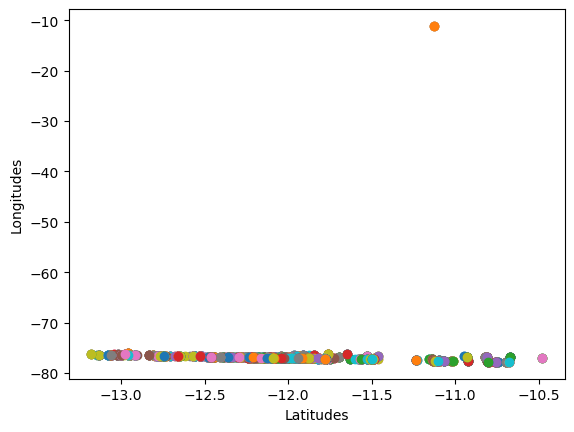

In [23]:
data_kmeans = []
latitudes = []
longitudes = []
zonas = []
df = pd.DataFrame()
for incidencia in df_filter['Emplazamiento']:
    if incidencia in df_distancia['Código Unico'].values:
        latitud = df_distancia.loc[df_distancia['Código Unico'] == incidencia, 'Latitud'].values[0]
        longitud = df_distancia.loc[df_distancia['Código Unico'] == incidencia, 'Longitud'].values[0]
        zona = df_distancia.loc[df_distancia['Código Unico'] == incidencia, 'Zona'].values[0]
        latitudes.append(latitud)
        longitudes.append(longitud)
        zonas.append(zona)
        data_kmeans.append([latitud, longitud])
        plt.scatter(latitud,longitud)
        plt.xlabel('Latitudes')
        plt.ylabel('Longitudes')

In [41]:
data_kmeans

[[-12.05231, -77.03419],
 [-12.1147543, -77.03357019],
 [-11.9515, -76.9871],
 [-12.021278, -77.031694],
 [-12.027299, -76.951018],
 [-12.000019, -76.85091],
 [-12.165437, -77.025695],
 [-11.900163, -76.962771],
 [-12.11528, -77.01812],
 [-12.068409, -77.04624],
 [-11.9912, -77.09244],
 [-12.007056, -77.075833],
 [-12.0053, -77.0058],
 [-12.57102, -76.69171],
 [-12.0653, -77.01488],
 [-12.09311111, -77.00651667],
 [-12.0308776, -76.9997476],
 [-11.6472222, -76.2325],
 [-11.814428, -77.132425],
 [-11.9832, -76.97697],
 [-12.09311111, -77.00651667],
 [-11.96233, -77.05656],
 [-12.96091667, -76.14175],
 [-11.9947117, -76.8285305],
 [-12.94884, -76.38243],
 [-11.984642, -76.996261],
 [-12.037021, -76.961681],
 [-12.06118, -77.00477],
 [-12.0733285, -77.0300235],
 [-12.777194, -76.598417],
 [-12.22497, -76.97281],
 [-12.008025, -77.0863494],
 [-12.02458, -77.082129],
 [-11.6472222, -76.2325],
 [-12.17293, -76.97768],
 [-12.041132, -76.720973],
 [-11.835809, -77.046508],
 [-12.028306, -77.06

In [42]:
features = ['latitudes', 'longitudes']
df[features]

,latitudes,longitudes
0,-12.052310,-77.034190
1,-12.114754,-77.033570
2,-11.951500,-76.987100
3,-12.021278,-77.031694
4,-12.027299,-76.951018
...,...,...
4967,-13.062948,-76.454195
4968,-11.117576,-77.610323
4969,-11.101920,-77.601020
4970,-11.233031,-77.364033


In [24]:
df['latitudes'] =  latitudes
df['longitudes'] = longitudes
df['zona'] = zonas

In [36]:
df = df[~((df['latitudes'] == -11.12745) & (df['longitudes'] == -11.12745))]

c:\Users\selen\anaconda3\envs\telefonica\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\selen\anaconda3\envs\telefonica\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\selen\anaconda3\envs\telefonica\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
c:\Users\selen\anaconda3\envs\telefonica\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of

Text(0, 0.5, 'Sum of Squared Error (SSE)')

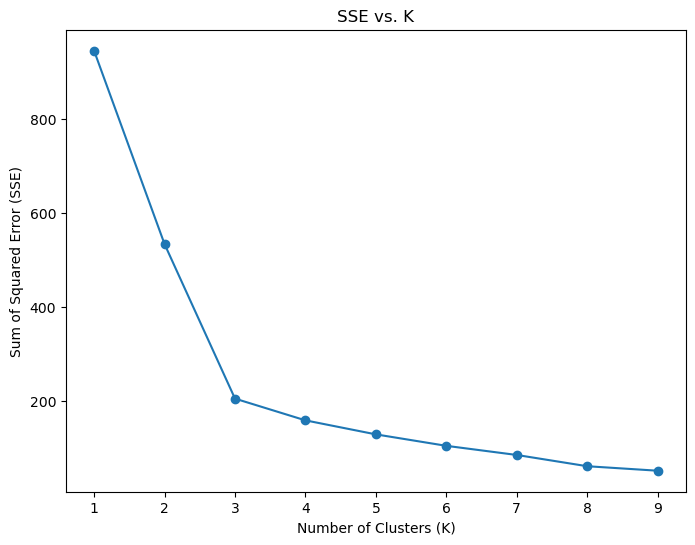

In [43]:

sse = []

k_rng = range(1, 10) 

for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(df[features]) 
    sse.append(km.inertia_)

plt.figure(figsize=(8, 6))
plt.plot(k_rng, sse, marker='o', linestyle='-')
plt.title('SSE vs. K')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Sum of Squared Error (SSE)')

In [50]:
km = KMeans(n_clusters=4)
y_predicted = km.fit_predict(df[features])
y_predicted

df['c'] = y_predicted

c:\Users\selen\anaconda3\envs\telefonica\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\selen\AppData\Local\Temp\ipykernel_13196\268297393.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['c'] = y_predicted


In [51]:
centroids = km.cluster_centers_
centroids[0]

array([-12.10423907, -76.97118836])

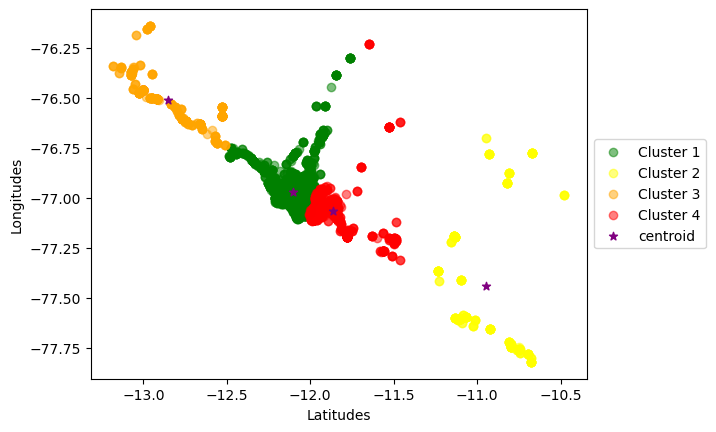

In [53]:
df1 = df[df.c==0]
df2 = df[df.c==1]
df3 = df[df.c==2]
df4 = df[df.c==3]
#df5 = df[df.c==4]
#df6 = df[df.c==5]
#df7 = df[df.c==6]
#df8 = df[df.c==7]
#df9 = df[df.c==8]
#df10 = df[df.c==9]
alpha_value = 0.5

plt.scatter(df1['latitudes'],df1['longitudes'],color='green',label='Cluster 1', alpha=alpha_value)
plt.scatter(df2['latitudes'],df2['longitudes'],color='yellow', label='Cluster 2',alpha=alpha_value)
plt.scatter(df3['latitudes'],df3['longitudes'],color='orange',label='Cluster 3', alpha=alpha_value)
plt.scatter(df4['latitudes'],df4['longitudes'],color='red',label='Cluster 4', alpha=alpha_value)
#plt.scatter(df5['latitudes'],df5['longitudes'],color='pink',label='Cluster 5', alpha=alpha_value)
#plt.scatter(df6['latitudes'],df6['longitudes'],color='cyan',label='Cluster 6', alpha=alpha_value)
#plt.scatter(df7['latitudes'],df7['longitudes'],color='brown',label='Cluster 7',alpha=alpha_value)
#plt.scatter(df8['latitudes'],df8['longitudes'],color='blue',label='Cluster 8', alpha=alpha_value)
#plt.scatter(df9['latitudes'],df9['longitudes'],color='black',label='Cluster 9',alpha=alpha_value)
#plt.scatter(df10['latitudes'],df10['longitudes'],color='gold',label='Cluster 10',alpha=alpha_value)


#plt.scatter(dfb['latitud'],dfb['longitud'],color='red', label='Zona 1', marker = '+' )
#plt.scatter(dfc['latitud'],dfc['longitud'],color='red', label='Zona 2', marker = '+' )
#plt.scatter(dfd['latitud'],dfd['longitud'],color='red', label='Zona 3', marker = '+' )
plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],color='purple',marker='*',label='centroid')
plt.xlabel('Latitudes')
plt.ylabel('Longitudes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

In [57]:
# Se calcula el número de puntos por cada cluster

data_centroides = {
    'Cluster': [],
    'Latitud': [],
    'Longitud':[],
    'Cluster_Count': []
    
}

cluster_labels = km.labels_
from collections import Counter
cluster_counts = dict(Counter(cluster_labels))
cluster_counts
for i in range(4):
    data_centroides['Cluster'].append(i)
    data_centroides['Latitud'].append(centroids[i][0])
    data_centroides['Longitud'].append(centroids[i][1])
    data_centroides['Cluster_Count'].append(cluster_counts[i])
    
    print(f'Para el cluster {i} se tiene las coordenadas {centroids[i]} con n {cluster_counts[i]}')

    df_cluster_info = pd.DataFrame(data_centroides)
    

Para el cluster 0 se tiene las coordenadas [-12.10423907 -76.97118836] con n 3171
Para el cluster 1 se tiene las coordenadas [-10.95029519 -77.44129663] con n 259
Para el cluster 2 se tiene las coordenadas [-12.85080388 -76.50972548] con n 419
Para el cluster 3 se tiene las coordenadas [-11.86157656 -77.0673892 ] con n 1120


In [14]:
df

,latitudes,longitudes,zona,c
0,-12.179665,-77.015026,Zona 2,5
1,-11.874043,-77.014860,Zona 3,8
2,-12.213259,-76.937821,Zona 2,3
3,-12.075156,-76.974237,Zona 2,9
4,-12.066750,-77.010973,Zona 3,0
...,...,...,...,...
5935,-11.889200,-77.037400,Zona 3,8
5936,-12.157389,-77.015950,Zona 2,5
5937,-12.093038,-76.960201,Zona 2,9
5938,-11.981300,-76.984300,Zona 3,4


In [15]:
df_cluster_info

,Cluster,Latitud,Longitud,Cluster_Count
0,0,-12.078665,-77.039309,1759
1,1,-11.792588,-77.160287,176
2,2,-12.045123,-76.858714,321
3,3,-12.243384,-76.896931,332
4,4,-11.971556,-76.992235,393
5,5,-12.161266,-76.988018,889
6,6,-11.950558,-76.722230,115
7,7,-11.992486,-77.072391,647
8,8,-11.896164,-77.046675,552
9,9,-12.059469,-76.959057,756


In [55]:

################################################################################################################################
def haversine_distance(lat1, lon1, lat2, lon2):
  
    earth_radius = 6371.0
    
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = earth_radius * c
    
    return distance


def cluster_center_to_farthest_point_distance(cluster_points):
    # Calculate the center of the cluster
    center_lat = sum(point[0] for point in cluster_points) / len(cluster_points)
    center_lon = sum(point[1] for point in cluster_points) / len(cluster_points)

    max_distance = 0
    for point in cluster_points:
        distance = haversine_distance(center_lat, center_lon, point[0], point[1])
        max_distance = max(max_distance, distance)
    
    return max_distance





In [58]:
# Assuming you have a list of DataFrames, e.g., df_list, where each DataFrame corresponds to a cluster
df_list = [df1, df2, df3, df4]

distance_per_cluster = []
distance_km = []
for i, df in enumerate(df_list, start=1):
    cluster_points = list(zip(df['latitudes'], df['longitudes']))
    max_distance = cluster_center_to_farthest_point_distance(cluster_points)
    print(f"La distancia entre el centro del cluster {i} y el punto más lejano es {max_distance:.2f} kilometers.")
    distance_per_cluster.append(max_distance)
df_cluster_info['distancia_km'] =distance_per_cluster

La distancia entre el centro del cluster 1 y el punto más lejano es 82.48 kilometers.
La distancia entre el centro del cluster 2 y el punto más lejano es 81.04 kilometers.
La distancia entre el centro del cluster 3 y el punto más lejano es 44.93 kilometers.
La distancia entre el centro del cluster 4 y el punto más lejano es 93.96 kilometers.


In [18]:
df_cluster_info

,Cluster,Latitud,Longitud,Cluster_Count,distancia_km
0,0,-12.078665,-77.039309,1759,7.467001
1,1,-11.792588,-77.160287,176,8.450761
2,2,-12.045123,-76.858714,321,11.535173
3,3,-12.243384,-76.896931,332,21.435486
4,4,-11.971556,-76.992235,393,9.513741
5,5,-12.161266,-76.988018,889,8.805730
6,6,-11.950558,-76.722230,115,9.147556
7,7,-11.992486,-77.072391,647,6.812810
8,8,-11.896164,-77.046675,552,14.038824
9,9,-12.059469,-76.959057,756,8.059173


# # Visualizacion de zonas

In [59]:
import matplotlib.pyplot as plt

# Assuming you have already defined dfb, dfc, dfd, and km as per your code
alpha_value = 0.3

plt.scatter(dfb['Latitud'], dfb['Longitud'], color='pink', label='Zona 1', marker='+', alpha=alpha_value)
plt.scatter(dfc['Latitud'], dfc['Longitud'], color='blue', label='Zona 2', marker='+', alpha=alpha_value)
plt.scatter(dfd['Latitud'], dfd['Longitud'], color='yellow', label='Zona 3', marker='+', alpha=alpha_value)
plt.scatter(km.cluster_centers_[:, 0], km.cluster_centers_[:, 1], color='red', marker='*', label='centroid')

# Add labels to each cluster's centroid
for i, centroid in enumerate(km.cluster_centers_):
    plt.annotate(f'Cluster {i + 1}', (centroid[0], centroid[1]), textcoords="offset points", xytext=(0, 10), ha='center')

plt.xlabel('Latitudes')
plt.ylabel('Longitudes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.show()


NameError: name 'dfb' is not defined

In [38]:
zona_cluster = ['zona 1','zona 3','zona 2','zona 2','zona 3','zona 2','zona 3','zona 3','zona 3','zona 2']
df_cluster_info['zona'] =zona_cluster

In [39]:
df_cluster_info

,Cluster,Latitud,Longitud,Cluster_Count,distancia_km,zona
0,0,-12.078665,-77.039309,1759,7.467001,zona 1
1,1,-11.792588,-77.160287,176,8.450761,zona 3
2,2,-12.045123,-76.858714,321,11.535173,zona 2
3,3,-12.243384,-76.896931,332,21.435486,zona 2
4,4,-11.971556,-76.992235,393,9.513741,zona 3
5,5,-12.161266,-76.988018,889,8.805730,zona 2
6,6,-11.950558,-76.722230,115,9.147556,zona 3
7,7,-11.992486,-77.072391,647,6.812810,zona 3
8,8,-11.896164,-77.046675,552,14.038824,zona 3
9,9,-12.059469,-76.959057,756,8.059173,zona 2


In [40]:
#Se exportan los excels

#excel con info de los clusters
df_cluster_info.to_excel('cluster_info.xlsx', index=False)
df.to_excel('incidencias_cluster.xlsx', index=False)

In [17]:
import pandas as pd
df = pd.read_excel('cluster_info.xlsx')

print(df.head())


   Cluster    Latitud   Longitud  Cluster_Count  distancia_km    zona
0        0 -12.078665 -77.039309           1759      7.467001  zona 1
1        1 -11.792588 -77.160287            176      8.450761  zona 3
2        2 -12.045123 -76.858714            321     11.535173  zona 2
3        3 -12.243384 -76.896931            332     21.435486  zona 2
4        4 -11.971556 -76.992235            393      9.513741  zona 3


In [18]:
df_zona1 = df[df['zona']=='zona 1']
df_zona2 = df[df['zona']=='zona 2']
df_zona3 = df[df['zona']=='zona 3']

In [24]:
df_zona2

,Cluster,Latitud,Longitud,Cluster_Count,distancia_km,zona
2,2,-12.045123,-76.858714,321,11.535173,zona 2
3,3,-12.243384,-76.896931,332,21.435486,zona 2
5,5,-12.161266,-76.988018,889,8.805730,zona 2
9,9,-12.059469,-76.959057,756,8.059173,zona 2


In [31]:
def calculate_middle_point(lat1, lon1, lat2, lon2):
    # Calculate the average latitude and longitude
    middle_lat = (lat1 + lat2) / 2
    middle_lon = (lon1 + lon2) / 2
    return middle_lat, middle_lon

# Example usage:
lat1 = -12.059469  # Latitude of point 1
lon1 = -76.959057  # Longitude of point 1

lat2 = -12.161266 # Latitude of point 2
lon2 = -76.988018  # Longitude of point 2

middle_lat_zone2, middle_lon_zone2 = calculate_middle_point(lat1, lon1, lat2, lon2)
print("Middle Point Latitude:", middle_lat_zone2)
print("Middle Point Longitude:", middle_lon_zone2)


Middle Point Latitude: -12.110367499999999
Middle Point Longitude: -76.97353749999999


In [32]:
df_zona3

,Cluster,Latitud,Longitud,Cluster_Count,distancia_km,zona
1,1,-11.792588,-77.160287,176,8.450761,zona 3
4,4,-11.971556,-76.992235,393,9.513741,zona 3
6,6,-11.950558,-76.722230,115,9.147556,zona 3
7,7,-11.992486,-77.072391,647,6.812810,zona 3
8,8,-11.896164,-77.046675,552,14.038824,zona 3


In [33]:
# Example usage:
lat1 = -11.896164  # Latitude of point 1
lon1 = -77.046675  # Longitude of point 1

lat2 = -11.992486 # Latitude of point 2
lon2 = -77.072391  # Longitude of point 2

middle_lat_zone3, middle_lon_zone3 = calculate_middle_point(lat1, lon1, lat2, lon2)
print("Middle Point Latitude:", middle_lat)
print("Middle Point Longitude:", middle_lon)

Middle Point Latitude: -11.944325
Middle Point Longitude: -77.05953299999999


In [34]:
df_zona1

,Cluster,Latitud,Longitud,Cluster_Count,distancia_km,zona
0,0,-12.078665,-77.039309,1759,7.467001,zona 1


In [40]:
import pandas as pd

# Create a list of data containing latitude, longitude, and zone
data = [
    {"Latitude": -12.078665, "Longitude": -77.039309, "Zone": "Zone1"},
    {"Latitude": middle_lat_zone2, "Longitude": middle_lon_zone2, "Zone": "Zone2"},
    {"Latitude": middle_lat_zone3, "Longitude": middle_lon_zone3, "Zone": "Zone3"},
    # Add more data as needed
]

# Create a DataFrame from the data
df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
df.to_excel('location_final_data.xlsx', index=False)

In [37]:
df

,Latitude,Longitude,Zone
0,-12.078665,-77.039309,Zone1
1,-12.110367,-76.973537,Zone2
2,-11.944325,-77.059533,Zone3


In [4]:
import pandas as pd
df = pd.read_excel('location_final_data.xlsx')
print(df.head())

    Latitude  Longitude              Zone  Distancia 
0 -12.078665 -77.039309             Zone1         NaN
1 -12.110368 -76.973537             Zone2         NaN
2 -11.944325 -77.059533             Zone3         NaN
3 -12.064185 -76.968248          Base Ate         NaN
4 -12.067660 -77.038350  Base Jesus Maria         NaN


In [14]:
import math
def haversine_distance(lat1, lon1, lat2, lon2):
  
    earth_radius = 6371.0
    
    lat1, lon1, lat2, lon2 = map(math.radians, [lat1, lon1, lat2, lon2])
    
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = math.sin(dlat / 2)**2 + math.cos(lat1) * math.cos(lat2) * math.sin(dlon / 2)**2
    c = 2 * math.atan2(math.sqrt(a), math.sqrt(1 - a))

    distance = earth_radius * c
    
    return distance

In [20]:
df

,Latitude,Longitude,Zone,Distancia
0,-12.078665,-77.039309,Zone1,NaN
1,-12.110368,-76.973537,Zone2,NaN
2,-11.944325,-77.059533,Zone3,NaN
3,-12.064185,-76.968248,Base Ate,NaN
4,-12.067660,-77.038350,Base Jesus Maria,NaN
5,-11.973614,-77.088940,Base Norte,NaN


In [18]:
row_1 = df.iloc[0]
row_2 = df.iloc[4]
zone1_distance = haversine_distance(row_1['Latitude'],row_1['Longitude'], row_2['Latitude'], row_2['Longitude'])
zone1_distance

1.2281351119689559

In [21]:
row_1 = df.iloc[1]
row_2 = df.iloc[3]
zone2_distance = haversine_distance(row_1['Latitude'],row_1['Longitude'], row_2['Latitude'], row_2['Longitude'])
zone2_distance

5.167319904331537

In [22]:
row_1 = df.iloc[2]
row_2 = df.iloc[5]
zone1_distance = haversine_distance(row_1['Latitude'],row_1['Longitude'], row_2['Latitude'], row_2['Longitude'])
zone1_distance

4.565072345127004